<a href="https://colab.research.google.com/github/KunalVaidya99/Image-Colorization-Using-Deep-Learning/blob/main/ChromaGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
from google.colab import drive
drive.mount("/content/gdrive/")

Mounted at /content/gdrive/


In [3]:
import tensorflow as tf
import keras
import keras.backend as K
from keras.layers import (Conv2D,Conv2DTranspose,UpSampling2D,MaxPooling2D,Input
                          ,Activation,Concatenate,BatchNormalization,Flatten,Concatenate
                          ,Dense,RepeatVector,Reshape)
from keras.optimizers import Adam
from keras.layers.advanced_activations import LeakyReLU
from keras.utils import plot_model
from keras.models import Model,Sequential
import numpy as np
from keras.preprocessing.image import load_img
from PIL import Image
import os
import matplotlib.pyplot as plt
import pickle
import random
import progressbar
from skimage.color import gray2rgb
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from keras.applications import VGG16
from keras.preprocessing.image import load_img,img_to_array

Using TensorFlow backend.


Extracting Features for all images using VGG16

In [ ]:
def extract_features(directory):

  model = VGG16(include_top=True,weights="imagenet",classes=1000)
  features = dict()
  count = 0
  for filename in os.listdir(directory):
   
    image = load_img(directory+filename,target_size=(224,224))
    img_array = img_to_array(image)
    img_array = img_array.reshape((1,224,224,3))
    feature = model.predict(img_array)
    features[filename] = feature
    count = count + 1

    if (count%1000==0):
      print("Completed Feature Extraction Of " + f"{count}") 

  return features

directory = "/content/gdrive/My Drive/val_256/"
features = extract_features(directory)       


Completed Feature Extraction Of 1000
Completed Feature Extraction Of 2000
Completed Feature Extraction Of 3000
Completed Feature Extraction Of 4000
Completed Feature Extraction Of 5000
Completed Feature Extraction Of 6000
Completed Feature Extraction Of 7000
Completed Feature Extraction Of 8000
Completed Feature Extraction Of 9000
Completed Feature Extraction Of 10000
Completed Feature Extraction Of 11000
Completed Feature Extraction Of 12000
Completed Feature Extraction Of 13000
Completed Feature Extraction Of 14000
Completed Feature Extraction Of 15000
Completed Feature Extraction Of 16000
Completed Feature Extraction Of 17000
Completed Feature Extraction Of 18000
Completed Feature Extraction Of 19000
Completed Feature Extraction Of 20000
Completed Feature Extraction Of 21000
Completed Feature Extraction Of 22000
Completed Feature Extraction Of 23000
Completed Feature Extraction Of 24000
Completed Feature Extraction Of 25000
Completed Feature Extraction Of 26000
Completed Feature Ex

In [ ]:
import pickle
f = open("/content/gdrive/My Drive/ImageColorization /chromaVGG16.pkl","wb")
pickle.dump(features,f)
f.close()

In [4]:
f_new = open("/content/gdrive/My Drive/ImageColorization /chromaVGG16.pkl","rb")
features_new = pickle.load(f_new)
f_new.close()

In [5]:
class DataGenerator():

  def __init__(self,features,directory,dim=(224,224),batch_size=32,n_channels=3):
    
    self.directory = directory
    self.dim = dim
    self.batch_size=batch_size
    self.n_channels = n_channels
    self.features = features
    

  def epoch_end(self,filenames):
    np.random.shuffle(filenames)

  def generate_batch(self,step_number,filenames):
    

    batch_filenames = filenames[step_number*self.batch_size:(step_number+1)*self.batch_size]

    gray_image = np.empty((self.batch_size,*self.dim,self.n_channels))
    color_image = np.empty((self.batch_size,*self.dim,self.n_channels))
    VGG16_target = np.empty((self.batch_size,1000))
    count = 0


    for filename in batch_filenames:
      image = Image.open(self.directory +"/" + filename)
      image = image.resize((224,224))


      if (np.array(image).shape==(224,224,3)):
        
        gray = (np.array(image.convert("L")))
        gray_image[count] = gray2rgb(gray)/255
        color_image[count] = np.array(image)/255
        VGG16_target[count] = self.features[filename]
        count = count + 1

    return gray_image,color_image,VGG16_target    

In [37]:
def patch_discriminator(img_shape):

  input_img = Input(shape=img_shape)

  X = Conv2D(filters=64,kernel_size=(4,4),strides=(2,2),padding='same')(input_img)
  X = BatchNormalization(axis=-1)(X)
  X = LeakyReLU(alpha=0.2)(X)

  X = Conv2D(filters=128,kernel_size=(4,4),strides=(2,2),padding='same')(X)
  X = BatchNormalization(axis=-1)(X)
  X = LeakyReLU(alpha=0.2)(X)

  X = Conv2D(filters=256,kernel_size=(4,4),strides=(2,2),padding='same')(X)
  X = BatchNormalization(axis=-1)(X)
  X = LeakyReLU(alpha=0.2)(X)

  X = Conv2D(filters=512,kernel_size=(4,4),strides=(1,1),padding='same')(X)
  X = BatchNormalization(axis=-1)(X)
  X = LeakyReLU(alpha=0.2)(X)

  X = Conv2D(filters=1,kernel_size=(4,4),strides=(1,1),padding='same')(X)
 
  model = Model(inputs=input_img,outputs=X)

  return model


In [38]:
 VGG16model = VGG16(include_top=False,weights="imagenet",classes=1000)
 #for layer in VGG16model.layers:
  # layer.trainable = False

In [39]:
def generator(img_shape):

  input_img = Input(shape=img_shape)
  X = input_img

  for layer in VGG16model.layers[1:-6]:
    X = layer(X)
    
  VGG16_output = X 
  #print(VGG16_output.shape)
  X = Conv2D(filters=512,kernel_size=(3,3),strides=(2,2),padding="same")(X)
  X = BatchNormalization(axis=-1)(X)
  X = Activation('relu')(X)

  X = Conv2D(filters=512,kernel_size=(3,3),strides=(1,1),padding="same")(X)
  X = BatchNormalization(axis=-1)(X)
  X = Activation('relu')(X)

  X = Conv2D(filters=512,kernel_size=(3,3),strides=(2,2),padding="same")(X)
  X = BatchNormalization(axis=-1)(X)
  X = Activation('relu')(X)

  X = Conv2D(filters=512,kernel_size=(3,3),strides=(1,1),padding="same")(X)
  X = BatchNormalization(axis=-1)(X)
  X = Activation('relu')(X)

  color_distribution = Flatten()(X)
  color_distribution = Dense(units=4096)(color_distribution)
  color_distribution = Dense(units=4096)(color_distribution)
  color_distribution = Dense(units=1000,activation='softmax',name='colordistribution')(color_distribution)

  fusion = Flatten()(X)
  fusion = Dense(units=1024)(fusion)
  fusion = Dense(units=512)(fusion)
  fusion = Dense(units=256)(fusion)
  fusion = RepeatVector(28*28)(fusion)
  fusion = Reshape((28,28,256))(fusion)

  encoder_output = Conv2D(filters=512,kernel_size=(3,3),strides=(1,1),padding="same")(VGG16_output)
  encoder_output = BatchNormalization(axis=-1)(encoder_output)
  encoder_output = Activation('relu')(encoder_output)
  encoder_output = Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),padding="same")(VGG16_output)
  encoder_output = BatchNormalization(axis=-1)(encoder_output)
  encoder_output = Activation('relu')(encoder_output)

  encoder_output = Concatenate(axis=-1)([encoder_output,fusion])

  decoder = Conv2D(filters=256,kernel_size=(1,1),strides=(1,1),activation='relu',padding='same')(encoder_output)
  decoder = Conv2D(filters=128,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(decoder)
  decoder = UpSampling2D((2,2))(decoder)

  decoder = Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu')(decoder)
  decoder = Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu')(decoder)
  decoder = UpSampling2D((2,2))(decoder)

  decoder = Conv2D(filters=32,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu')(decoder)
  decoder = Conv2D(filters=3,kernel_size=(3,3),strides=(1,1),padding='same')(decoder)
  decoder = UpSampling2D((2,2))(decoder)


  model = Model(inputs=input_img,outputs=[decoder,color_distribution])

  return model

In [40]:
def chromaGAN(img_shape,discriminator,generator):
  X = Input(img_shape)
  image,color_distribution = generator(X)
  output = discriminator(image)
  model = Model(inputs=X,outputs=[image,color_distribution,output])
  return model

In [ ]:
chromaGAN = chromaGAN((224,224,3),patch_discriminator,generator)

In [41]:
opt = Adam(learning_rate=0.00002,beta_1=0.9,beta_2=0.999)
patch_discriminator = patch_discriminator((224,224,3))
patch_discriminator.compile(optimizer=opt,loss='mae',loss_weights=[1])
generator = generator((224,224,3))
patch_discriminator.load_weights("/content/gdrive/My Drive/ImageColorization /new_chromaGAN/disc_epoch12_step no.2000.h5")
generator.load_weights("/content/gdrive/My Drive/ImageColorization /new_chromaGAN/gen_epoch12_step no.2000.h5")
patch_discriminator.trainable = False
chromaGAN = chromaGAN((224,224,3),patch_discriminator,generator)
chromaGAN.compile(optimizer=opt,loss=["mse",keras.losses.kullback_leibler_divergence,'mae'],loss_weights=[5,0.003,0.1])

In [42]:
def summarize_performance(step,generator,gray_images,color_images,name = "Colorizer"):
  n_samples = 5
  

  images,_ = generator.predict(gray_images)
  for i in range(n_samples):
    plt.subplot(3, n_samples, 1 +i)
    plt.axis('off')
    plt.imshow(images[i])
    plt.title("Predicted")
  
  for i in range(n_samples):
    plt.subplot(3, n_samples, 1 + n_samples + i)
    plt.axis('off')
    plt.imshow(gray_images[i])
    plt.title("Gray")

  for i in range(n_samples):
    plt.subplot(3, n_samples, 1 + 2*n_samples+i)
    plt.axis('off')
    plt.imshow(color_images[i])
    plt.title("GT")
  

  filename1 = '%s_generated_plot_%06d.png' % (name, (step+1))
  plt.savefig(filename1)
  plt.close()

In [44]:
def train(generator,discriminator,chromaGAN,batch_size,epochs):
  
  directory = "/content/gdrive/My Drive/val_256/"
  n_steps = int(len(os.listdir(directory))/batch_size)
  filenames = os.listdir(directory)
  DataLoader = DataGenerator(features_new,directory,batch_size=batch_size)


  for epoch in range(12,epochs):
    DataLoader.epoch_end(filenames)
    print("**********************EPOCH "+f"{epoch+1}" + " *********************")
    print("\n")

    for step in progressbar.progressbar(range(n_steps)):

      gray_batch,color_batch,VGG16batch = DataLoader.generate_batch(step,filenames)
      
      
      gray_batch_gen,color_batch_gen,VGG16batch_gen = DataLoader.generate_batch(n_steps-step,filenames)

      fake_images,_ = generator.predict(x=gray_batch)
      real = np.ones((batch_size,28,28,1))
      fake = np.zeros((batch_size,28,28,1))

      d_loss1 = discriminator.train_on_batch(x=color_batch,y=real)
      d_loss2 = discriminator.train_on_batch(x=fake_images,y=fake)
      d_loss = [d_loss1,d_loss2]

      g_loss = chromaGAN.train_on_batch(x=gray_batch_gen,y=[color_batch_gen,VGG16batch_gen,real])

      if ((step+1)%50==0):
        
        idx1 = np.random.randint(0,n_steps)
        gray_images,color_images,_ = DataLoader.generate_batch(idx1,filenames)
        summarize_performance(step,generator,gray_images[:5],color_images[:5])
        print("Step Number :",step+1,sep="  ")
        print("Generator Loss :",g_loss,sep="  ")
        print("Discriminator Loss :",d_loss)
        print("\n")

      if ((step+1)%500==0):
        filename_disc = "/content/gdrive/My Drive/ImageColorization /new_chromaGAN/" + "disc_"+ "epoch" + f"{epoch+1}" +"_" + "step no." + f"{step+1}" +".h5"
        filename_gen = "/content/gdrive/My Drive/ImageColorization /new_chromaGAN/" + "gen_"+ "epoch" + f"{epoch+1}" +"_" + "step no." + f"{step+1}" +".h5"
        discriminator.save_weights(filename_disc)
        generator.save_weights(filename_gen)



In [36]:
train(generator,patch_discriminator,chromaGAN,batch_size=32,epochs=15)

N/A% (0 of 2030) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

**********************EPOCH 1 *********************




/tensorflow-1.15.2/python3.6/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


  0% (1 of 2030) |                       | Elapsed Time: 0:00:36 ETA:  20:24:13/tensorflow-1.15.2/python3.6/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
  2% (50 of 2030) |                      | Elapsed Time: 0:14:46 ETA:  13:50:55

Step Number :  50
Generator Loss :  [0.08448632, 0.05261919, 4.2515593, 0.19112454]
Discriminator Loss : [0.22972967, 0.1685625]




  4% (100 of 2030) |#                    | Elapsed Time: 0:29:20 ETA:  13:49:07

Step Number :  100
Generator Loss :  [0.06260737, 0.029063553, 3.996928, 0.21553029]
Discriminator Loss : [0.21678977, 0.21107824]




  7% (150 of 2030) |#                    | Elapsed Time: 0:44:14 ETA:  12:25:15

Step Number :  150
Generator Loss :  [0.06388149, 0.035782337, 3.617591, 0.17246374]
Discriminator Loss : [0.2503918, 0.16181472]




  9% (200 of 2030) |##                   | Elapsed Time: 0:58:31 ETA:  15:37:59

Step Number :  200
Generator Loss :  [0.10661562, 0.037861355, 3.8607144, 0.5717212]
Discriminator Loss : [0.48564032, 0.20230986]




 12% (250 of 2030) |##                   | Elapsed Time: 1:13:02 ETA:  13:07:24

Step Number :  250
Generator Loss :  [0.13007095, 0.06987598, 3.7830827, 0.48845723]
Discriminator Loss : [0.39949483, 0.5902223]




 14% (300 of 2030) |###                  | Elapsed Time: 1:27:30 ETA:   7:54:14

Step Number :  300
Generator Loss :  [0.12417872, 0.06856577, 3.6948795, 0.44528314]
Discriminator Loss : [0.30742723, 0.46018526]




 15% (307 of 2030) |###                  | Elapsed Time: 1:29:26 ETA:   7:51:56

KeyboardInterrupt: ignored

In [25]:
directory = "/content/gdrive/My Drive/val_256/"
filenames = os.listdir(directory)
data = DataGenerator(features_new,directory)
gray,color,_ = data.generate_batch(3,filenames)

In [45]:
p,_ = generator.predict(gray)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


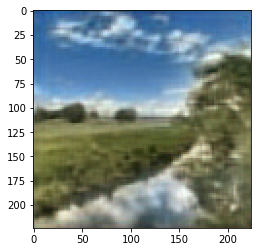

In [65]:
plt.imshow(p[7])

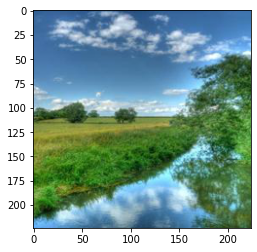

In [63]:
plt.imshow(color[7])